# Examinating the Use of DBSCAN as an Effective Multipath Filter

Nebiolo and Meyer (2021) removed multipath in a phased approach.  The first filter removed all but the first detection of every beacon tag epoch, as all other detections must be multipath.  The second filter, an implentation of k-Nearest Neighbors, used information on known multipath and assumed primary detections to classify detections as multipath.  Even after two rounds of filtering, it was apparent multipath remained, which biased clock syncrhonization.  This notebook explores the use of DBSCAN as an effective multipath filter.  

---
# Notebook Setup
We will use the following modules to assess the effectiveness of DBSCAN for identifying and removing multipath detections. This Notebook uses a combination of Bokeh and matplotlib for plotting. Please ensure both are installed prior to running.  

In [1]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np

---
# Import Data and Visualize
The following data came from Nebiolo and Meyer (2021) and represents a snippet of data, 20662 records in total, from the clock synchronization routine at receiver R07. The y-axis is clock drift measured in meters.   

In [2]:
dat = pd.read_csv(r"C:\Users\knebiolo\Desktop\jsats_Notebook_Test\Output\kats_test_dat.csv")

Visualize with Bokeh

In [3]:
output_notebook()
raw_plot = figure(title = "Distance Difference of Arrival")
raw_plot.scatter(dat.seconds, dat.DDoA)
show(raw_plot)

Loading BokehJS ...

---
# Create a Timeseries and Impute Missing Data
Data is never perfect and the receiver did not detect every beacon transmission.  Data gaps were imputed with a piecewise linear function.
We first, identify the first and last time step in seconds

In [4]:
t_min = dat.seconds.min()
t_max = dat.seconds.max()

In Nebiolo and Meyer (2021), the beacon tag had a 37.0 second pulse rate.  Let's use Numpy to create a timeseries

In [5]:
ts = np.arange(t_min,t_max,37.)

Then, we will use Scipy to fit a piecewise linear interpolator to the origial dataset.

In [6]:
f = interp1d(dat.seconds,dat.DDoA,kind = 'linear')

Now we will interpolate DDoA across our timeseries.

In [7]:
ddoa = f(ts)

And visualize 

In [8]:
int_plot = figure(title = "Interpolated Distance Difference of Arrival")
int_plot.scatter(ts, ddoa, color = 'red')
show(int_plot)

---
# Calculate the Euclidean Distance Between Observations
DBSCAN is a density-based clustering non-parametric algorithm, where given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away).  Thanks Wikipedia!

Anyway, distance between clusters is measured in Euclidean distance.  So the following cells computer the Euclidean Distance between pairs of observations.  Any observations with larger jump in DDoA than their neighbors would be in a different cluster.

In [9]:
euc_dist = np.sqrt(np.power(np.diff(ts),2)+np.power(np.diff(ddoa),2))

Make a histogram of these distances

(array([5.2465e+04, 2.7000e+01, 1.8000e+01, 1.0000e+01, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00, 4.0000e+00]),
 array([37.        , 40.62487819, 44.24975637, 47.87463456, 51.49951275,
        55.12439093, 58.74926912, 62.37414731, 65.99902549, 69.62390368,
        73.24878187]),
 <BarContainer object of 10 artists>)

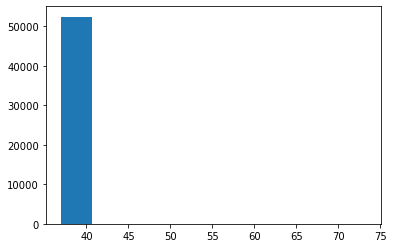

In [10]:
plt.hist(euc_dist)

Calculate extreme distances between points as .90, .95 and . 99 quanties to use as parameters in DBSCAN

In [11]:
ext_dist = np.quantile(euc_dist, [0.90,0.95,0.99])

---
# Apply DBSCAN
Next, we will apply DBSCAN using ScikitLearn.  There are two important parameters. The first, eps, is the maximum distance between two samples for one to be considered in the neighborhood of the other. eps is not a maximum bound on the distances of points within a cluster. It is the most important DBSCAN parameter to choose appropriately for your data set and distance function.  The other parameter is the number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.  The distance metric chosen was euclidean.

In [12]:
model = DBSCAN(eps = ext_dist[2] ,min_samples = 3, metric = 'euclidean').fit(np.vstack((ts,ddoa)).T)

---
# Filter Out Multipath
DBSCAN indicates points that are not within a cluster with a class label of -1. All other points are part of a cluster.  Create a dataframe of results, remove points with a class label of -1.

In [13]:
results = pd.DataFrame.from_dict({'ts':ts,'ddoa':ddoa,'class':model.labels_})
filtered = results[results['class'] != -1]

---
# Plot Cleaned Data

In [14]:
clean_plot = figure(title = "Multipath Cleaned Distance Difference of Arrival")
clean_plot.scatter(filtered.ts, filtered.ddoa, color = 'black')
show(clean_plot)